In [1]:
import tensorflow as tf
from keras.datasets import mnist
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from keras.layers import GRU, Dense
import os
import seaborn as sns
from sklearn import metrics
from timeit import default_timer as timer
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train=x_train/255.0
x_test=x_test/255.0

In [3]:
f1 = []
log_loss = []  
accuracy = []
class PredictionCallback(tf.keras.callbacks.Callback):    
  def on_epoch_end(self, epoch, logs={}):
    y_pred = self.model.predict(x_test)
    index = []
    for array in y_pred:
        for i in range(len(array)):
            if max(array, key=lambda x: x) == array[i]:
                index.append(i)

    # Evaluate the model on training and testing data
    f1.append(metrics.f1_score(y_test, index , average='macro'))
    log_loss.append((metrics.log_loss(y_test, y_pred)))
    accuracy.append(metrics.balanced_accuracy_score(y_test, index))

In [4]:
class Model_Timer(tf.keras.callbacks.Callback):
    def __init__(self):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

In [5]:
model = Sequential([
    GRU(50,return_sequences=True),
    GRU(50,return_sequences=True),
    GRU(50,return_sequences=True),
    GRU(50),
    Dense(10, activation="softmax")
])
cb = Model_Timer()
# Compile the model
model.compile(optimizer=tf.optimizers.legacy.Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["MeanAbsoluteError","RootMeanSquaredError", "MeanSquaredError"])
model.fit(x_train, y_train, batch_size=8, epochs=10, validation_data=(x_test, y_test),callbacks=[PredictionCallback(), cb])

Epoch 1/10
7500/7500 [==============================] - 133s 17ms/step - loss: 0.2342 - mean_absolute_error: 4.3739 - root_mean_squared_error: 5.2329 - mean_squared_error: 27.3827 - val_loss: 0.0854 - val_mean_absolute_error: 4.3630 - val_root_mean_squared_error: 5.2285 - val_mean_squared_error: 27.3369
Epoch 2/10
7500/7500 [==============================] - 129s 17ms/step - loss: 0.0742 - mean_absolute_error: 4.3739 - root_mean_squared_error: 5.2337 - mean_squared_error: 27.3914 - val_loss: 0.0598 - val_mean_absolute_error: 4.3630 - val_root_mean_squared_error: 5.2286 - val_mean_squared_error: 27.3377
Epoch 3/10
7500/7500 [==============================] - 131s 17ms/step - loss: 0.0554 - mean_absolute_error: 4.3739 - root_mean_squared_error: 5.2338 - mean_squared_error: 27.3922 - val_loss: 0.0466 - val_mean_absolute_error: 4.3630 - val_root_mean_squared_error: 5.2286 - val_mean_squared_error: 27.3386
Epoch 4/10
7500/7500 [==============================] - 131s 17ms/step - loss: 0.0444

In [6]:
time_took_to_run = sum(cb.logs)
print(time_took_to_run)

1306.0454817498103


In [7]:
y_pred = model.predict(x_test)
index = []
for array in y_pred:
    for i in range(len(array)):
        if max(array, key=lambda x: x) == array[i]:
            index.append(i)

print("Accuracy (validation): " + str(metrics.accuracy_score(y_test, index)))
print(f"F1 Score: {metrics.f1_score(y_test, index , average='macro')}")
print(f"Log Loss: {metrics.log_loss(y_test, y_pred)}")
print(f"Confusion Matrix: {metrics.multilabel_confusion_matrix(y_test, index)}")
print("Max-Min Diff: " + str(max(accuracy)-min(accuracy)))

313/313 [==============================] - 2s 8ms/step
Accuracy (validation): 0.989
F1 Score: 0.988947348829344
Log Loss: 0.04007196339367153
Confusion Matrix: [[[9014    6]
  [   3  977]]

 [[8857    8]
  [   7 1128]]

 [[8952   16]
  [   6 1026]]

 [[8983    7]
  [   5 1005]]

 [[8992   26]
  [   8  974]]

 [[9102    6]
  [  15  877]]

 [[9029   13]
  [   9  949]]

 [[8963    9]
  [  20 1008]]

 [[9023    3]
  [  14  960]]

 [[8975   16]
  [  23  986]]]
Max-Min Diff: 0.01611551927449939


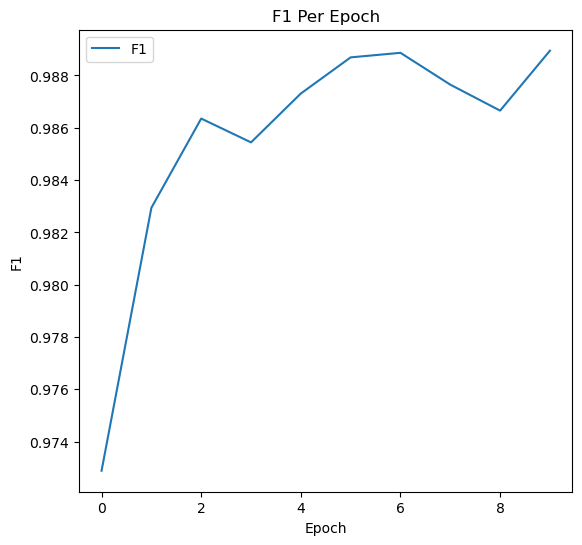

In [8]:
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.plot(f1, label="F1")
plt.title('F1 Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.legend()

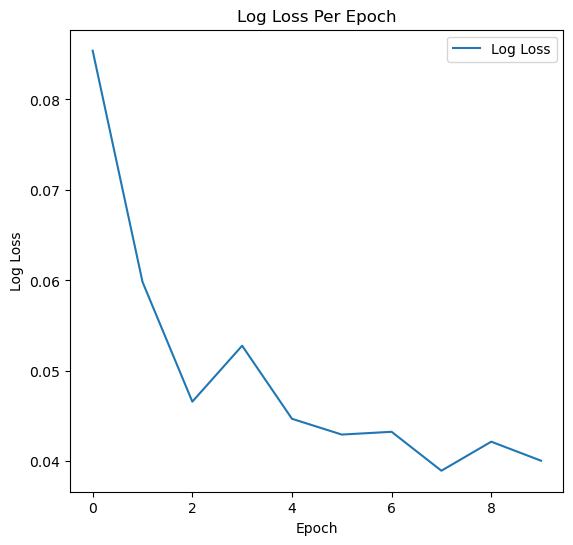

In [9]:
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.plot(log_loss, label="Log Loss")
plt.title('Log Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.legend()

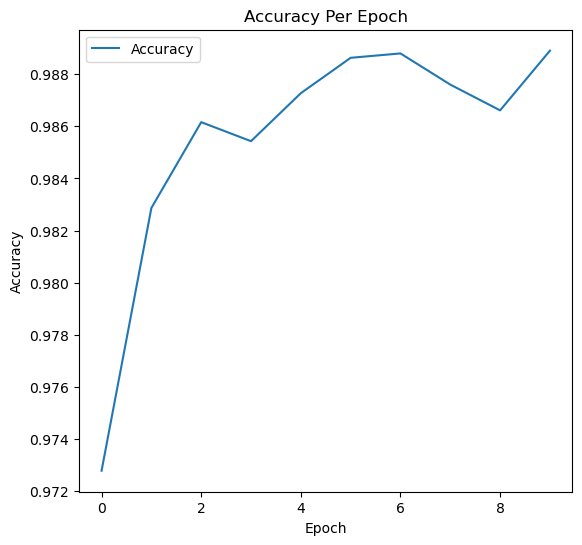

In [10]:
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.plot(accuracy, label="Accuracy")
plt.title('Accuracy Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

[[ 977    0    0    0    0    0    2    1    0    0]
 [   0 1128    3    0    2    0    2    0    0    0]
 [   1    1 1026    0    3    0    0    1    0    0]
 [   0    0    1 1005    0    2    0    0    0    2]
 [   0    0    1    0  974    0    4    1    0    2]
 [   0    0    0    4    0  877    5    1    0    5]
 [   2    2    0    0    1    2  949    0    2    0]
 [   0    4   10    0    3    0    0 1008    0    3]
 [   2    1    1    3    1    1    0    1  960    4]
 [   1    0    0    0   16    1    0    4    1  986]]


<Axes: >

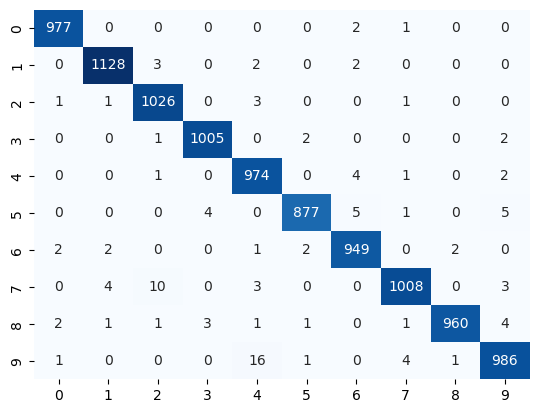

In [11]:
cm = metrics.confusion_matrix(y_test, index)
print(cm)
sns.heatmap(cm, cmap="Blues", cbar=False, annot=True, fmt='d')